In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

# Load the dataset

In [2]:
df = pd.read_csv('C:/Users/smrc/Downloads/BrentOilPrices.csv')
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df.set_index('Date', inplace=True)


In [3]:
# Check for missing values
print(df.isnull().sum())

Price    0
dtype: int64


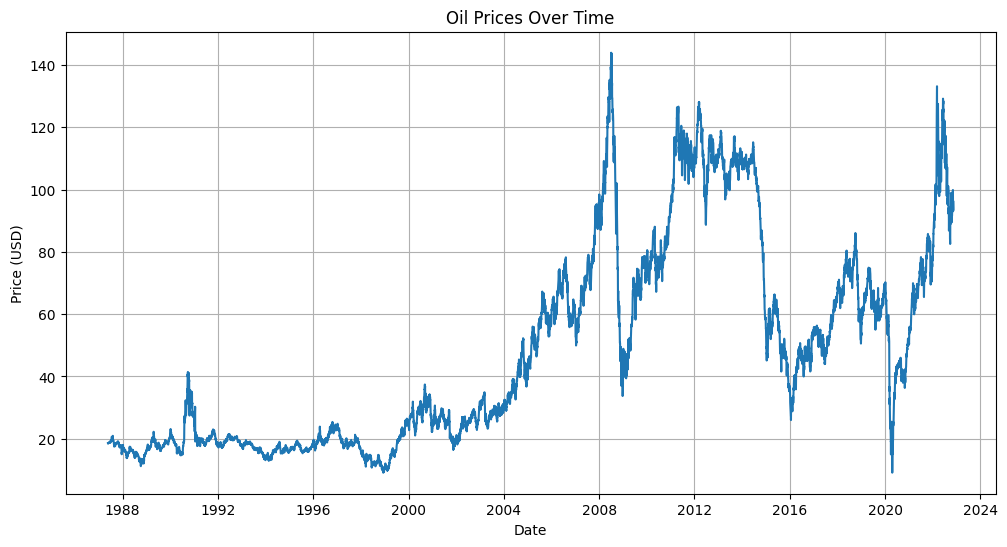

In [4]:
# Basic visualization
plt.figure(figsize=(12,6))
plt.plot(df['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid()
plt.show()

             Price
count  9011.000000
mean     48.420782
std      32.860110
min       9.100000
25%      19.050000
50%      38.570000
75%      70.090000
max     143.950000
ADF Statistic: -1.9938560113924675
p-value: 0.28927350489340287


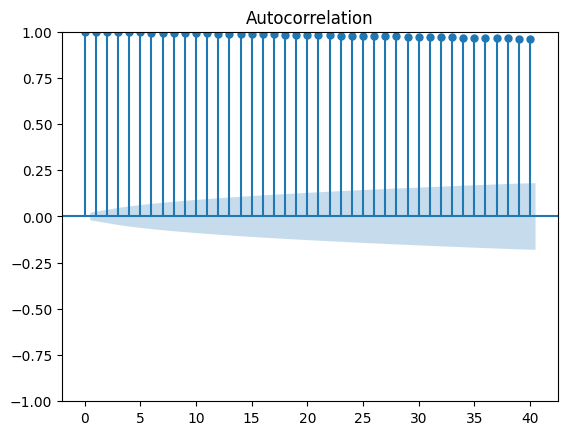

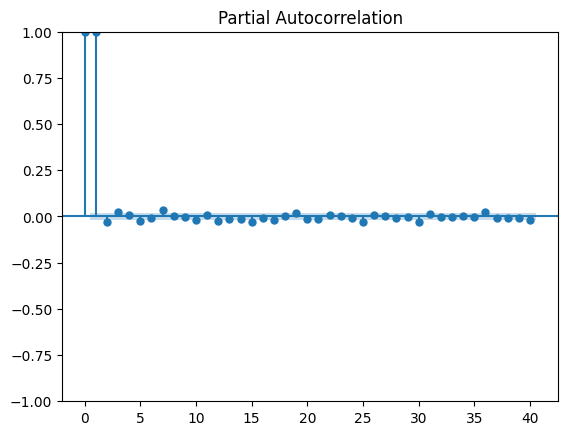

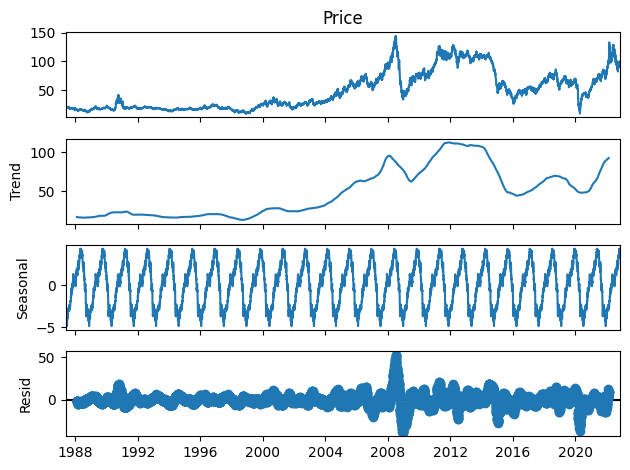

In [5]:
# Descriptive statistics
print(df.describe())

# Check stationarity with Augmented Dickey-Fuller test
result = adfuller(df['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Plot ACF and PACF
plot_acf(df['Price'], lags=40)
plot_pacf(df['Price'], lags=40)
plt.show()

# Decompose time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Price'], model='additive', period=365)
decomposition.plot()
plt.show()

### **Model Building**

**ARIMA IMPLEMENTATION**

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 8646
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -13096.589
Date:                Wed, 30 Apr 2025   AIC                          26209.179
Time:                        02:16:33   BIC                          26265.697
Sample:                             0   HQIC                         26228.449
                               - 8646                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0224      0.022     -1.020      0.308      -0.066       0.021
ar.L2          0.9315      0.021     44.938      0.000       0.891       0.972
ar.L3         -0.0155      0.009     -1.763      0.0

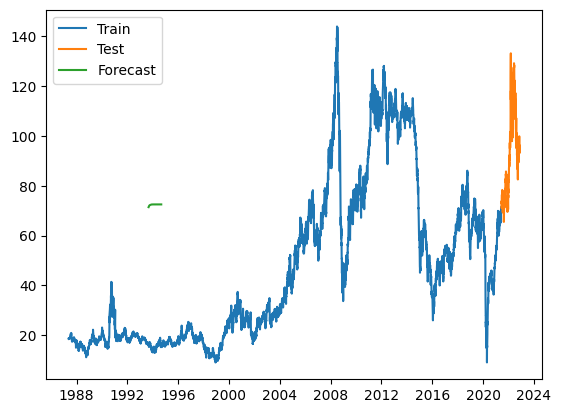

RMSE: 26.15205663399378


In [6]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Split data into train/test
train = df.iloc[:-365]
test = df.iloc[-365:]

# Fit ARIMA model
model = ARIMA(train['Price'], order=(5,1,2))
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=365)
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Price'], forecast))
print(f'RMSE: {rmse}')

**GARCH IMPLEMENTATION**

In [7]:
import sys
!{sys.executable} -m pip install arch



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
from arch import arch_model

# Fit GARCH model
garch = arch_model(train['Price'], vol='Garch', p=1, q=1)
garch_fit = garch.fit()
print(garch_fit.summary())

# Forecast volatility
forecasts = garch_fit.forecast(horizon=5)
print(forecasts.variance[-1:])

Iteration:      1,   Func. Count:      6,   Neg. LLF: 129105109745.60353
Iteration:      2,   Func. Count:     12,   Neg. LLF: 99970810770.61462
Iteration:      3,   Func. Count:     19,   Neg. LLF: 160689.0641637859
Iteration:      4,   Func. Count:     27,   Neg. LLF: 52230.97109583925
Iteration:      5,   Func. Count:     34,   Neg. LLF: 37308.10983763282
Iteration:      6,   Func. Count:     41,   Neg. LLF: 39452.4225306603
Iteration:      7,   Func. Count:     47,   Neg. LLF: 38514.88158602258
Iteration:      8,   Func. Count:     53,   Neg. LLF: 37279.51515933945
Iteration:      9,   Func. Count:     59,   Neg. LLF: 56548.51442034112
Iteration:     10,   Func. Count:     68,   Neg. LLF: 37755.393068576675
Iteration:     11,   Func. Count:     74,   Neg. LLF: 33321.78885030921
Iteration:     12,   Func. Count:     79,   Neg. LLF: 61970.16431154802
Iteration:     13,   Func. Count:     90,   Neg. LLF: 38149.69597110896
Iteration:     14,   Func. Count:     96,   Neg. LLF: 37907.899

**LSTM Implementation**

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Prepare sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

ImportError: Traceback (most recent call last):
  File "c:\Users\smrc\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.